In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_2.csv")

In [16]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["problemSize"] = dataFrame["problemSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Problem sizes:", sorted(dataFrame["problemSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)

Loaded rows: 280
Modes: ['reduction' 'no_reduction']
Problem sizes: [1000000, 5000000, 10000000, 50000000]
Thread counts: [1, 2, 4, 6, 8, 16, 32]


,testType,problemSize,numThreads,mode,timeSeconds,scalarProduct,runIndex,ompEnv
0,OpenMP_2,1000000,1,reduction,0.000638,250107.0,1,OMP_NUM_THREADS=1
1,OpenMP_2,1000000,1,reduction,0.000645,249857.0,2,OMP_NUM_THREADS=1
2,OpenMP_2,1000000,1,reduction,0.000637,249997.0,3,OMP_NUM_THREADS=1
3,OpenMP_2,1000000,1,reduction,0.000660,250361.0,4,OMP_NUM_THREADS=1
4,OpenMP_2,1000000,1,reduction,0.000742,249760.0,5,OMP_NUM_THREADS=1
5,OpenMP_2,1000000,2,reduction,0.000510,250037.0,1,OMP_NUM_THREADS=2
6,OpenMP_2,1000000,2,reduction,0.000498,249858.0,2,OMP_NUM_THREADS=2
7,OpenMP_2,1000000,2,reduction,0.000572,250145.0,3,OMP_NUM_THREADS=2


In [17]:
groupedFrame = dataFrame.groupby(["mode","problemSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","problemSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)

,mode,problemSize,numThreads,median,mean,std,count
0,no_reduction,1000000,1,0.000637,0.000667,0.000045,5
1,no_reduction,1000000,2,0.000588,0.000619,0.000095,5
2,no_reduction,1000000,4,0.000519,0.000532,0.000067,5
3,no_reduction,1000000,6,0.000619,0.000659,0.000132,5
4,no_reduction,1000000,8,0.000640,0.000644,0.000018,5
5,no_reduction,1000000,16,0.000878,0.000892,0.000075,5
6,no_reduction,1000000,32,0.001442,0.001418,0.000087,5
7,no_reduction,5000000,1,0.003147,0.003149,0.000011,5
8,no_reduction,5000000,2,0.002158,0.002177,0.000098,5
9,no_reduction,5000000,4,0.001782,0.001803,0.000129,5


In [18]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, problemSizeVal), subFrame in groupedDf.groupby(["mode","problemSize"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)

,mode,problemSize,numThreads,median,mean,std,count,speedup,efficiency
0,no_reduction,1000000,1,0.000637,0.000667,0.000045,5,1.000000,1.000000
1,no_reduction,1000000,2,0.000588,0.000619,0.000095,5,1.083007,0.541504
2,no_reduction,1000000,4,0.000519,0.000532,0.000067,5,1.225602,0.306400
3,no_reduction,1000000,6,0.000619,0.000659,0.000132,5,1.028096,0.171349
4,no_reduction,1000000,8,0.000640,0.000644,0.000018,5,0.994222,0.124278
5,no_reduction,1000000,16,0.000878,0.000892,0.000075,5,0.725501,0.045344
6,no_reduction,1000000,32,0.001442,0.001418,0.000087,5,0.441662,0.013802
7,no_reduction,5000000,1,0.003147,0.003149,0.000011,5,1.000000,1.000000
8,no_reduction,5000000,2,0.002158,0.002177,0.000098,5,1.457907,0.728953
9,no_reduction,5000000,4,0.001782,0.001803,0.000129,5,1.765670,0.441417


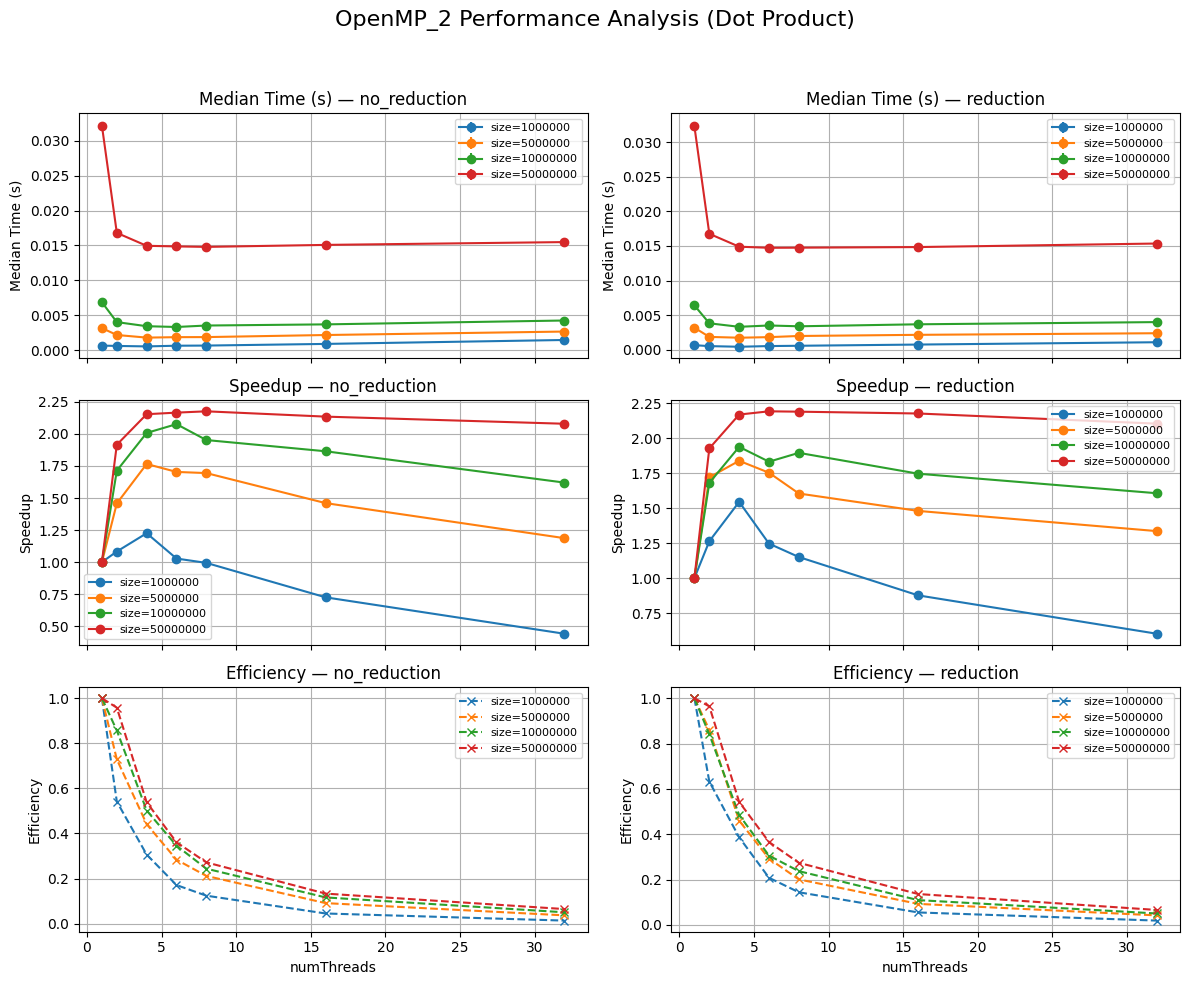

In [19]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()
for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        axIdx = rowIdx*2 + colIdx
        ax = axes[axIdx]
        for problemSizeVal in sorted(perfFrame["problemSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["problemSize"]==problemSizeVal)].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={problemSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={problemSizeVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numThreads")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)
plt.suptitle("OpenMP_2 Performance Analysis (Dot Product)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [20]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="problemSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)


=== mode: no_reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000
numThreads,,,,
1,0.000637,0.003147,0.006865,0.032204
2,0.000588,0.002158,0.004006,0.016811
4,0.000519,0.001782,0.003419,0.014952
6,0.000619,0.001847,0.003306,0.014867
8,0.000640,0.001857,0.003516,0.014797
16,0.000878,0.002155,0.003681,0.015084
32,0.001442,0.002651,0.004236,0.015488



=== mode: no_reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,1.083007,1.457907,1.713494,1.915668
4,1.225602,1.765670,2.007780,2.153818
6,1.028096,1.703628,2.076344,2.166132
8,0.994222,1.694636,1.952334,2.176350
16,0.725501,1.460343,1.864722,2.134927
32,0.441662,1.187172,1.620462,2.079347



=== mode: reduction — median time (s) ===


problemSize,1000000,5000000,10000000,50000000
numThreads,,,,
1,0.000645,0.003173,0.006404,0.032308
2,0.000510,0.001844,0.003810,0.016761
4,0.000418,0.001725,0.003304,0.014891
6,0.000517,0.001809,0.003495,0.014733
8,0.000561,0.001977,0.003378,0.014751
16,0.000736,0.002143,0.003667,0.014839
32,0.001071,0.002374,0.003985,0.015351



=== mode: reduction — speedup ===


problemSize,1000000,5000000,10000000,50000000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,1.263859,1.720887,1.680927,1.927622
4,1.545389,1.838985,1.938701,2.169711
6,1.246763,1.753703,1.832580,2.192861
8,1.150910,1.605099,1.895888,2.190289
16,0.876630,1.480679,1.746714,2.177241
32,0.602315,1.336197,1.607031,2.104666


In [21]:
summaryRows = []
for (modeVal, problemSizeVal), sub in perfFrame.groupby(["mode","problemSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "problemSize": problemSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })

summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","problemSize"])
display(summaryAnalysisFrame)


,mode,problemSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,no_reduction,1000000,4,1.225602,0.306400,0.000637
1,no_reduction,5000000,4,1.765670,0.441417,0.003147
2,no_reduction,10000000,6,2.076344,0.346057,0.006865
3,no_reduction,50000000,8,2.176350,0.272044,0.032204
4,reduction,1000000,4,1.545389,0.386347,0.000645
5,reduction,5000000,4,1.838985,0.459746,0.003173
6,reduction,10000000,4,1.938701,0.484675,0.006404
7,reduction,50000000,6,2.192861,0.365477,0.032308
